# Terminator

Procederé a aplicar todo lo que no aprendí este semestre según mis calificaciones 

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
import numpy as np
from sklearn import preprocessing as ps
import matplotlib.pyplot as plt
import seaborn as sns

In [191]:
d2=pd.read_csv("Data_set_200_280.csv")

In [192]:
d2

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,5.556148e-07,4.686493e-10,0.000008
1,Healthy,6.529095e-07,2.819616e-10,0.000009
2,Healthy,6.096350e-07,2.985569e-10,0.000009
3,Healthy,5.567451e-07,2.556868e-10,0.000008
4,Healthy,5.016411e-07,3.071286e-10,0.000007
...,...,...,...,...
4914,Wheezes,1.017147e-05,1.164674e-08,0.000136
4915,Wheezes,9.649835e-06,8.796041e-09,0.000129
4916,Wheezes,1.124116e-06,7.448796e-10,0.000015
4917,Wheezes,9.903341e-07,4.516410e-10,0.000013


Inicialmente se hace un encoder para convertir las variables cualitativas en cuantitativas en este caso solo afectando la columna de estados

In [193]:
encoder = ps.LabelEncoder()
d2["Estado"]=encoder.fit_transform(d2["Estado"])
print(d2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4919 entries, 0 to 4918
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Estado     4919 non-null   int32  
 1   Sumatoria  4919 non-null   float64
 2   Mediana    4919 non-null   float64
 3   Varianza   4919 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 134.6 KB
None


En este caso Sano:1 crepitante:0 y silibante:2

Normalizaremos los valores de cada columna dividiéndolos por el valor máximo para tener valores entre 0 y 1 en cada columna

In [195]:
for i in d2.columns.values[1:]:
    d2[i]=d2[i]/np.max(d2[i])

In [196]:
d2

,Estado,Sumatoria,Mediana,Varianza
0,1,0.000354,0.000049,0.000325
1,1,0.000416,0.000029,0.000369
2,1,0.000388,0.000031,0.000362
3,1,0.000354,0.000027,0.000315
4,1,0.000319,0.000032,0.000276
...,...,...,...,...
4914,2,0.006475,0.001218,0.005667
4915,2,0.006143,0.000920,0.005367
4916,2,0.000716,0.000078,0.000624
4917,2,0.000630,0.000047,0.000523


Ahora revisemos la correlación con nuestro target de predicción que seria el estado

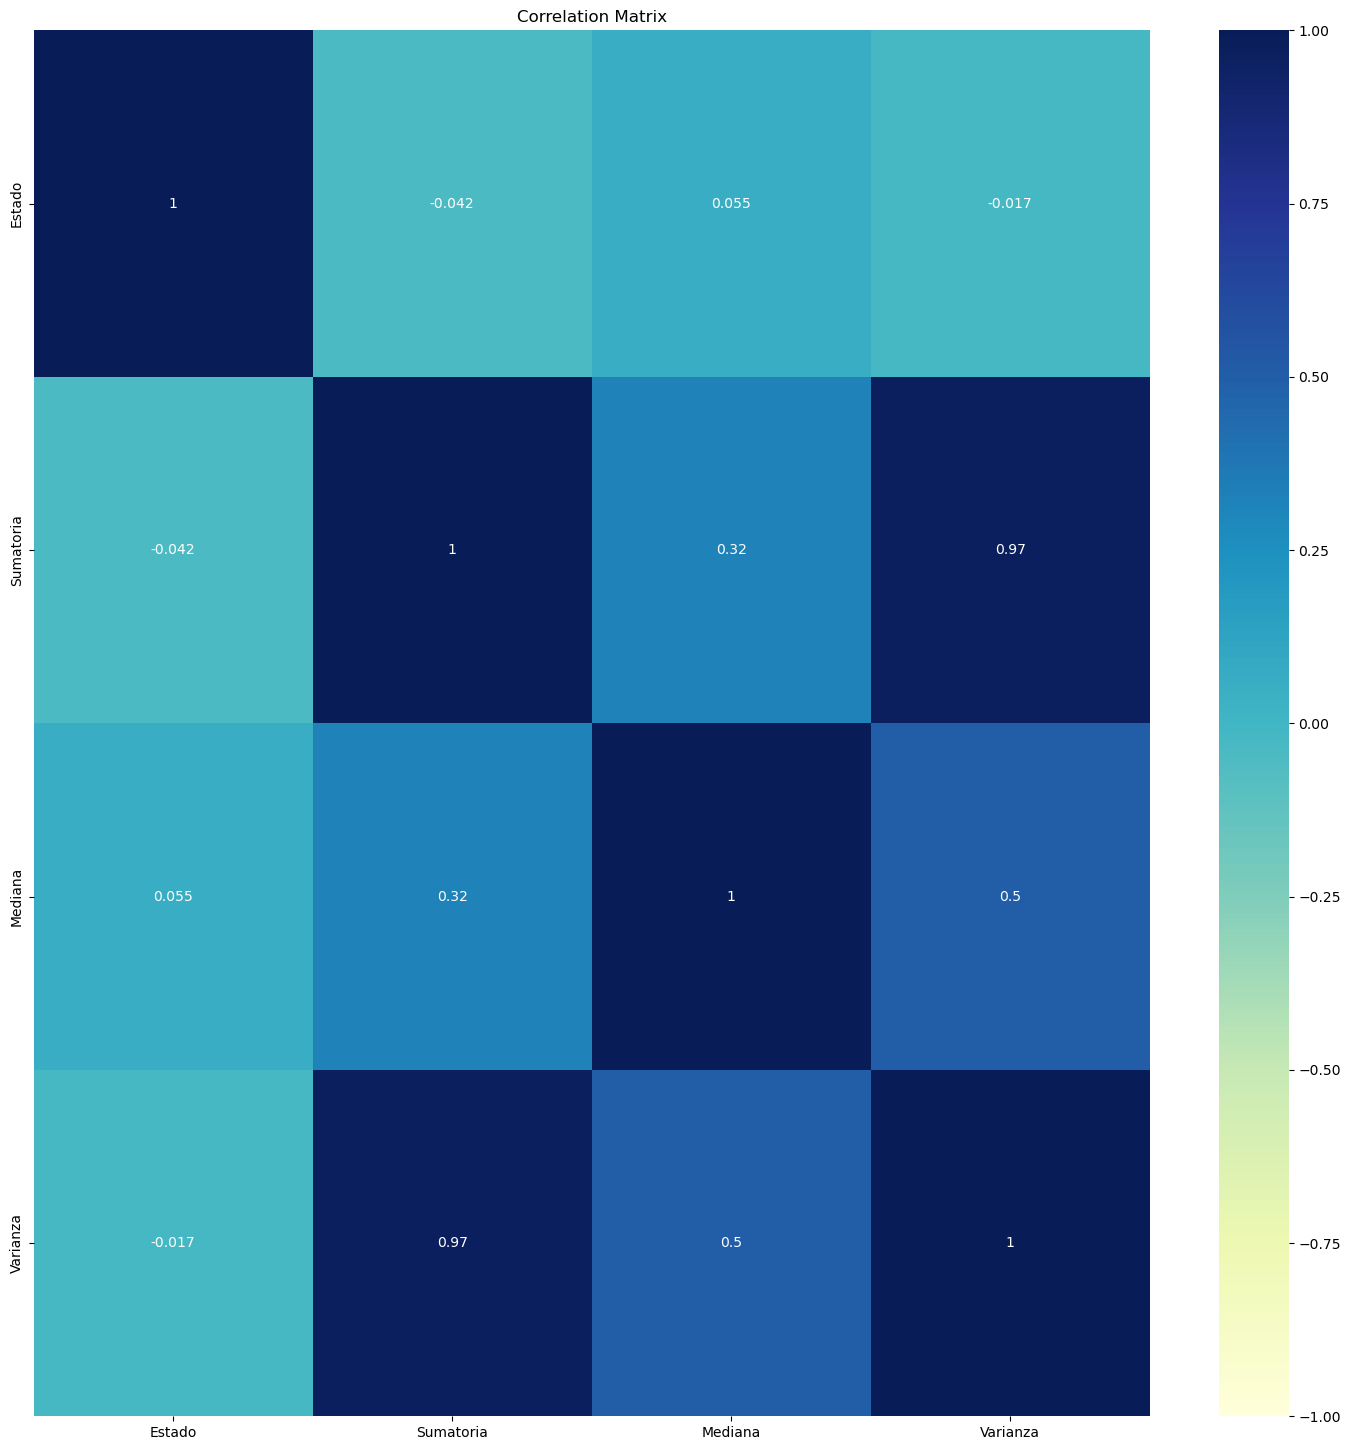

In [197]:
corr_matrix = d2.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()

In [198]:
target_corr_df = pd.DataFrame(corr_matrix["Estado"].sort_values(ascending=False))
target_corr_df 

,Estado
Estado,1.000000
Mediana,0.054825
Varianza,-0.016609
Sumatoria,-0.042180


En este caso podemos observar que el estado va relacionado mayormente con la mediana que en el caso de la varianza o la suma, con esto en mente priorizaremos este parámetro para la generación de las redes neuronales

# 1. Ciclos normales y ciclos crepitantes

## Entrenamiento

In [200]:
con=(d2.Estado.values==1)|(d2.Estado.values==0)
x=d2.drop(["Estado"],axis=1)[con]
y=d2.Estado.values[con]
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)

print (Xtv.shape, Xts.shape)

(4264, 3) (4264,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(2984, 3) (1280, 3)


In [77]:
from itertools import product
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [238]:
def me_da_pereza(i,Xtv,ytv,Xts,yts,target_names):
    for a in i:
        a.fit(Xtv,ytv)
        predict_train = a.predict(Xtv)
        predict_test = a.predict(Xts)
        print("Train ",a.activation)
        print("------------")
        print("Square error:",mean_squared_error(ytv,predict_train))
        print(classification_report(ytv,predict_train))
        mc_train = confusion_matrix(ytv,predict_train)
        plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix train '+a.activation)
        print("------------")
        print("Test ",a.activation)
        print("Square error:",mean_squared_error(yts,predict_test))
        print(classification_report(yts,predict_test))
        mc_train = confusion_matrix(yts,predict_test)
        plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix test '+a.activation)

En este caso vamos a probar con varias redes neuronales, cambiaremos la activación para cambiar la arquitectura lo mismo que el solucionador de ser necesario, esto cambiara la forma del sigmoide, en el proceso se ira permutando los valores hasta encontrar un modelo más adecuado para la predicción 

In [232]:
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]

## Resultados

Train  relu
------------
Square error: 0.34517426273458446
              precision    recall  f1-score   support

           0       0.58      0.44      0.50      1179
           1       0.69      0.79      0.74      1805

    accuracy                           0.65      2984
   macro avg       0.63      0.62      0.62      2984
weighted avg       0.65      0.65      0.64      2984

Confusion matrix, without normalization
[[ 520  659]
 [ 371 1434]]
------------
Test  relu
Square error: 0.35078125
              precision    recall  f1-score   support

           0       0.50      0.44      0.47       452
           1       0.71      0.76      0.74       828

    accuracy                           0.65      1280
   macro avg       0.61      0.60      0.60      1280
weighted avg       0.64      0.65      0.64      1280

Confusion matrix, without normalization
[[199 253]
 [196 632]]
Train  identity
------------
Square error: 0.3806970509383378
              precision    recall  f1-score   

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

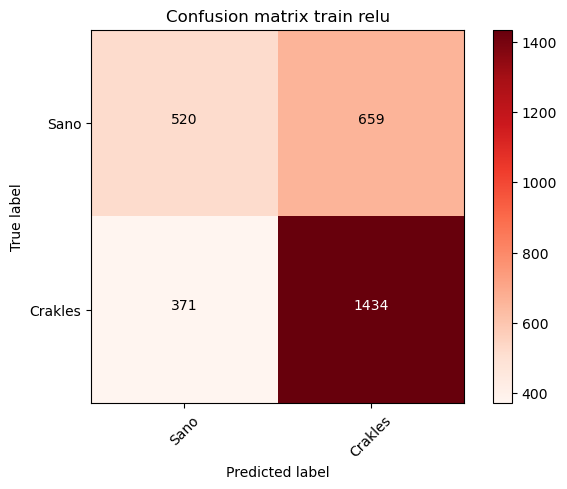

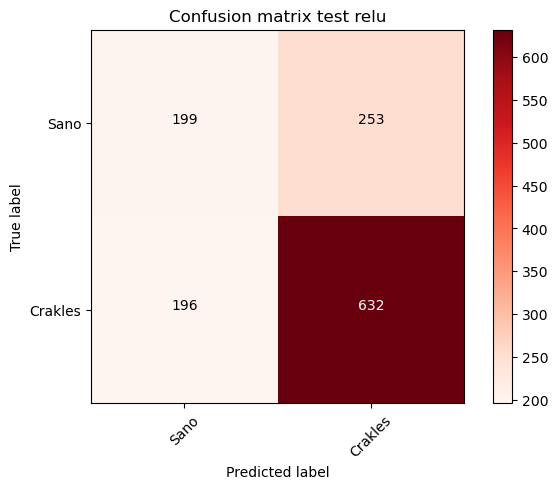

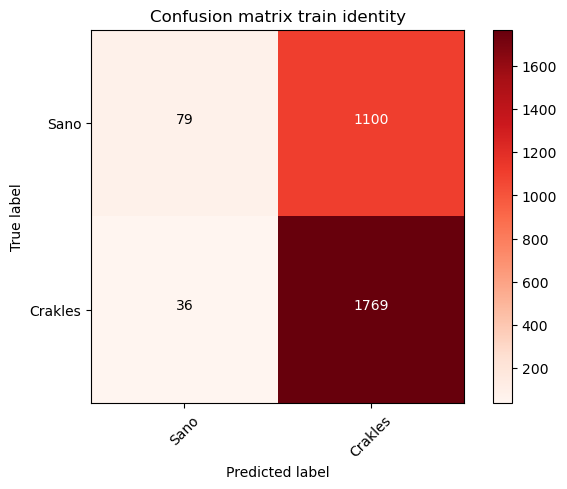

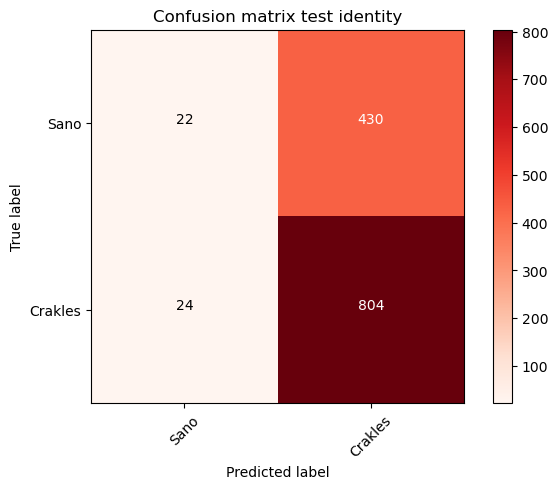

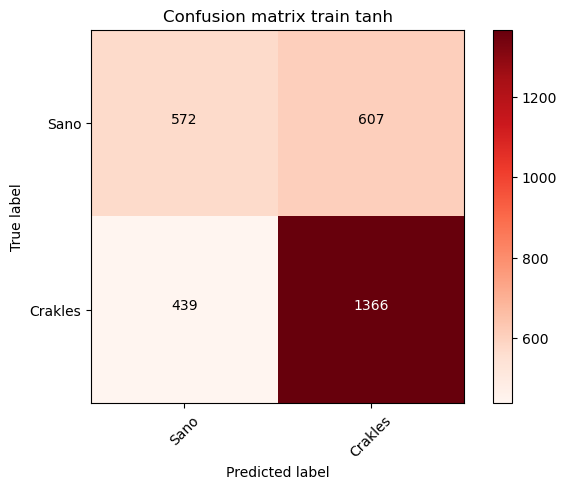

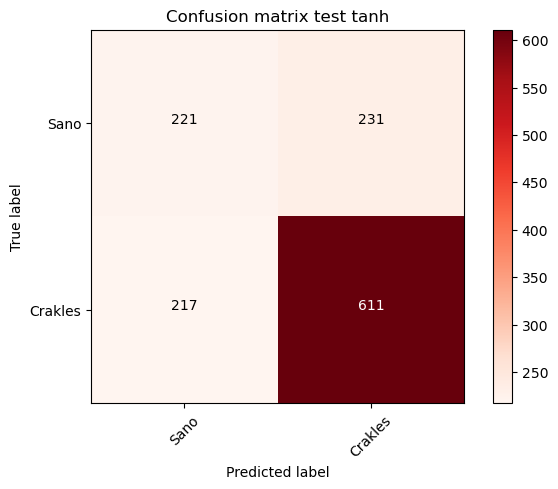

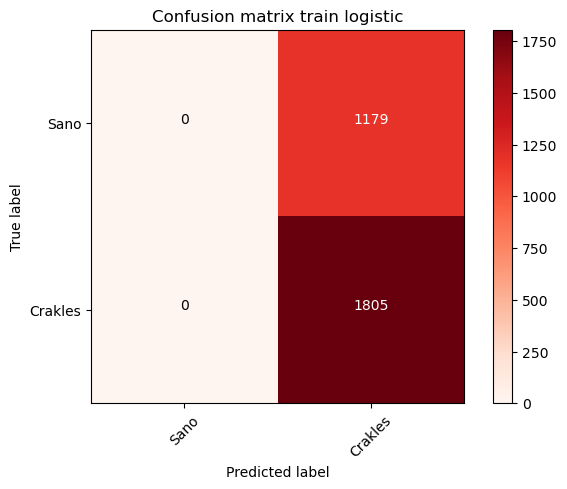

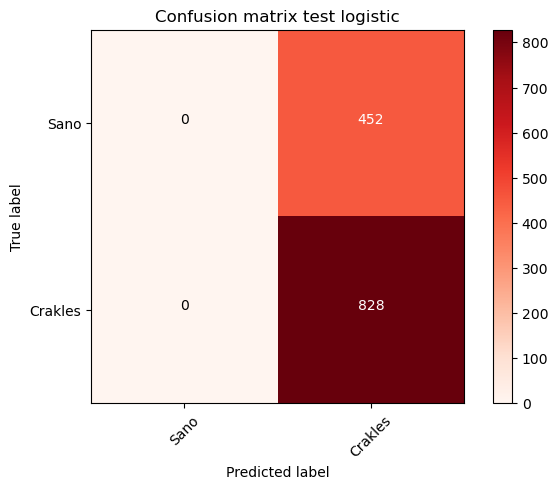

In [239]:
me_da_pereza(a,Xtv,ytv,Xts,yts,['Sano','Crakles'])

# 2. Ciclos normales y ciclos silbantes

(3288, 3) (3288,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(2301, 3) (987, 3)
Train  relu
------------
Square error: 0.21034332898739677
              precision    recall  f1-score   support

           1       0.79      1.00      0.88      1817
           2       0.00      0.00      0.00       484

    accuracy                           0.79      2301
   macro avg       0.39      0.50      0.44      2301
weighted avg       0.62      0.79      0.70      2301

Confusion matrix, without normalization
[[1817    0]
 [ 484    0]]
------------
Test  relu
Square error: 0.17325227963525835
              precision    recall  f1-score   support

           1       0.83      1.00      0.91       816
           2       0.00      0.00      0.00       171

    accuracy                           0.83       987
   macro avg       0.41      0.50      0.45       987
weighted avg       0.68      0.83      0.75       987

Confusion matrix, without normalization
[[816   0]
 [171   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  identity
------------
Square error: 0.21034332898739677
              precision    recall  f1-score   support

           1       0.79      1.00      0.88      1817
           2       0.00      0.00      0.00       484

    accuracy                           0.79      2301
   macro avg       0.39      0.50      0.44      2301
weighted avg       0.62      0.79      0.70      2301

Confusion matrix, without normalization
[[1817    0]
 [ 484    0]]
------------
Test  identity
Square error: 0.17325227963525835
              precision    recall  f1-score   support

           1       0.83      1.00      0.91       816
           2       0.00      0.00      0.00       171

    accuracy                           0.83       987
   macro avg       0.41      0.50      0.45       987
weighted avg       0.68      0.83      0.75       987

Confusion matrix, without normalization
[[816   0]
 [171   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  tanh
------------
Square error: 0.21034332898739677
              precision    recall  f1-score   support

           1       0.79      1.00      0.88      1817
           2       0.00      0.00      0.00       484

    accuracy                           0.79      2301
   macro avg       0.39      0.50      0.44      2301
weighted avg       0.62      0.79      0.70      2301

Confusion matrix, without normalization
[[1817    0]
 [ 484    0]]
------------
Test  tanh
Square error: 0.17325227963525835
              precision    recall  f1-score   support

           1       0.83      1.00      0.91       816
           2       0.00      0.00      0.00       171

    accuracy                           0.83       987
   macro avg       0.41      0.50      0.45       987
weighted avg       0.68      0.83      0.75       987

Confusion matrix, without normalization
[[816   0]
 [171   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  logistic
------------
Square error: 0.21034332898739677
              precision    recall  f1-score   support

           1       0.79      1.00      0.88      1817
           2       0.00      0.00      0.00       484

    accuracy                           0.79      2301
   macro avg       0.39      0.50      0.44      2301
weighted avg       0.62      0.79      0.70      2301

Confusion matrix, without normalization
[[1817    0]
 [ 484    0]]
------------
Test  logistic
Square error: 0.17325227963525835
              precision    recall  f1-score   support

           1       0.83      1.00      0.91       816
           2       0.00      0.00      0.00       171

    accuracy                           0.83       987
   macro avg       0.41      0.50      0.45       987
weighted avg       0.68      0.83      0.75       987

Confusion matrix, without normalization
[[816   0]
 [171   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

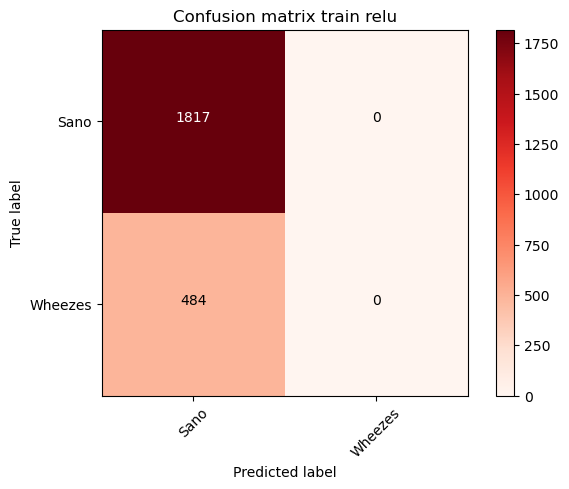

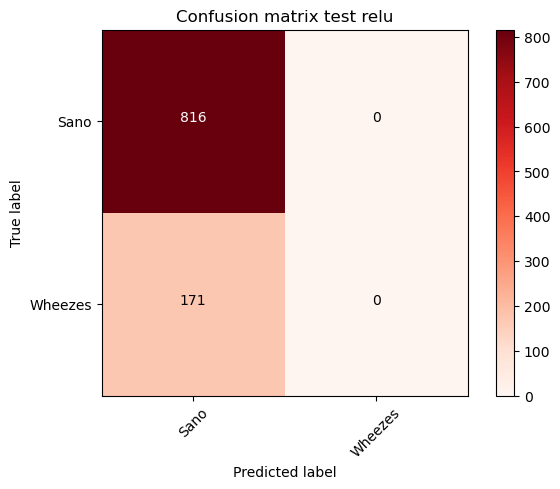

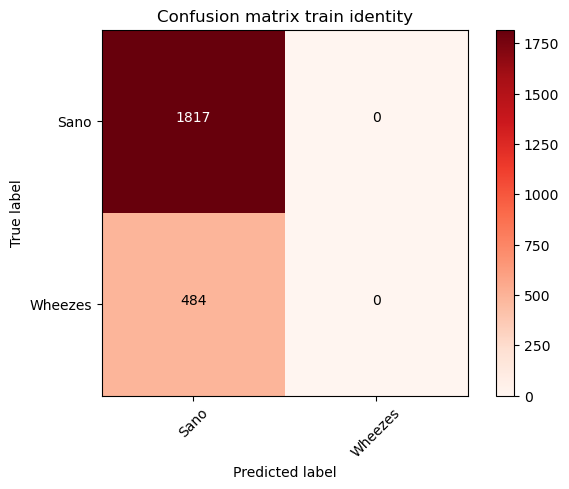

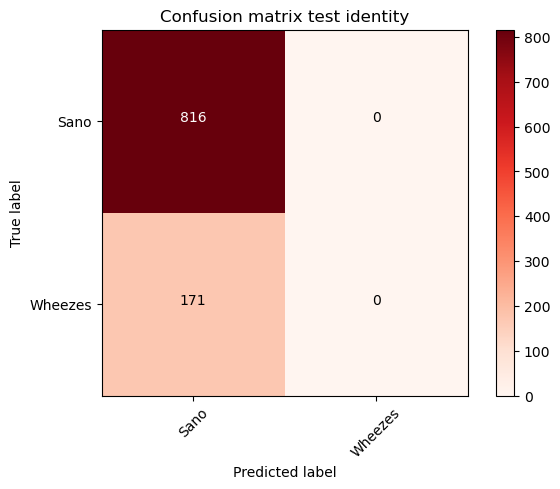

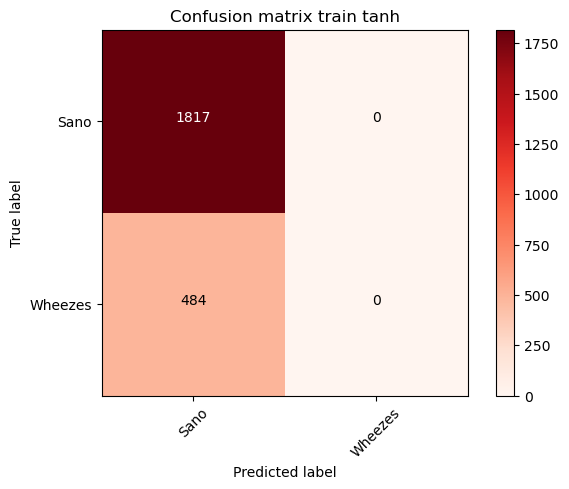

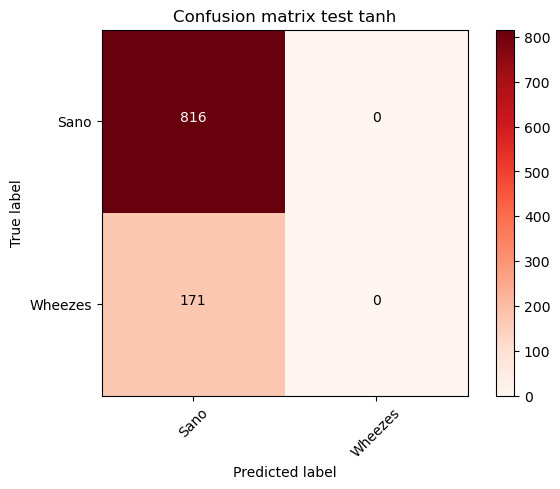

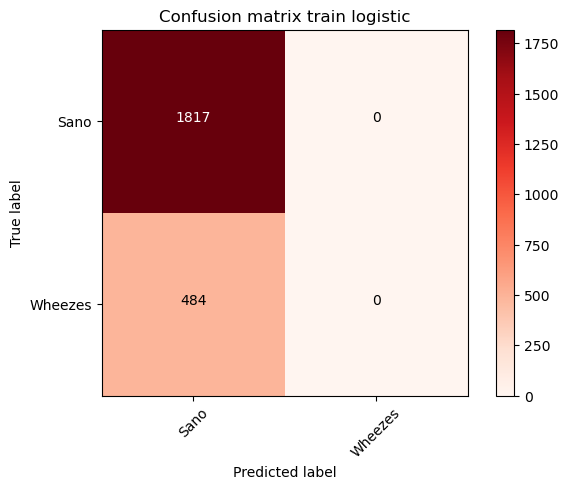

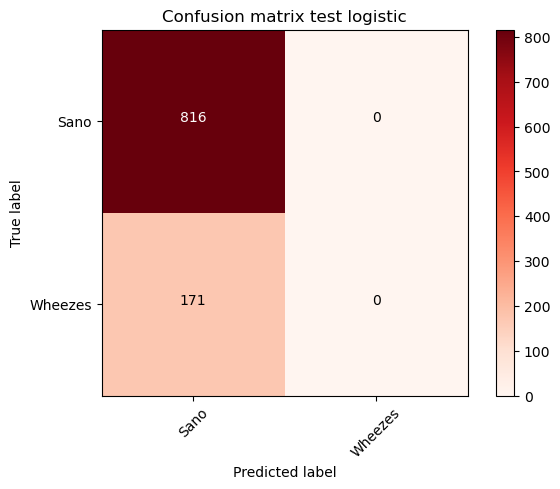

In [244]:
con=(d2.Estado.values==1)|(d2.Estado.values==2)
x=d2.drop(["Estado"],axis=1)[con]
y=d2.Estado.values[con]
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)

print (Xtv.shape, Xts.shape)
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,['Sano','Wheezes'])

## 3. Silibantes y crepitantes

(2286, 3) (2286,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(1600, 3) (686, 3)
Train  relu
------------
Square error: 1.1275
              precision    recall  f1-score   support

           0       0.72      0.99      0.83      1140
           2       0.63      0.05      0.09       460

    accuracy                           0.72      1600
   macro avg       0.67      0.52      0.46      1600
weighted avg       0.69      0.72      0.62      1600

Confusion matrix, without normalization
[[1127   13]
 [ 438   22]]
------------
Test  relu
Square error: 1.154518950437318
              precision    recall  f1-score   support

           0       0.72      0.98      0.83       491
           2       0.42      0.04      0.07       195

    accuracy                           0.71       686
   macro avg       0.57      0.51      0.45       686
weighted avg       0.63      0.71      0.61       686

Confusion matrix, without normalization
[[480  11]
 [187   8]]
Train  identity
---------

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

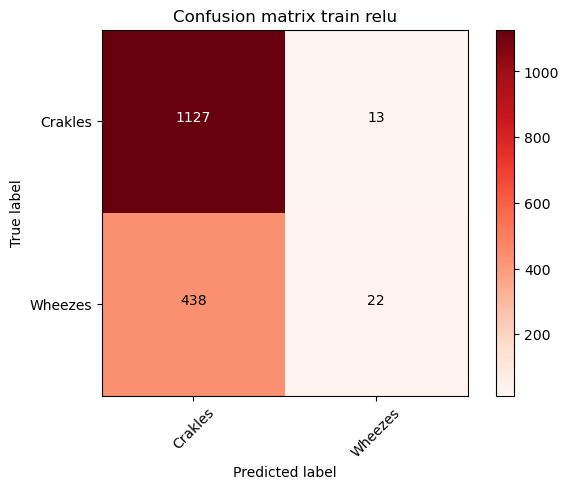

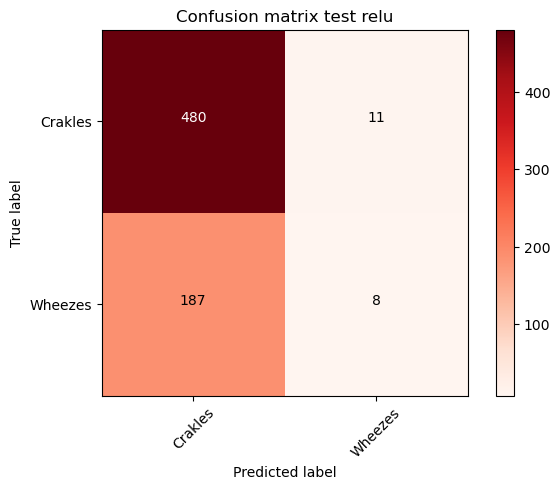

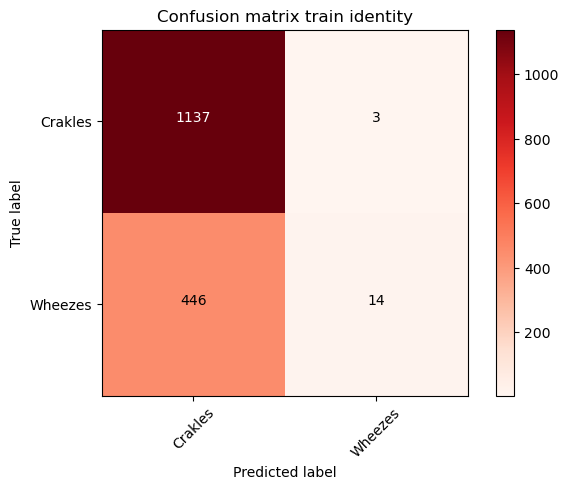

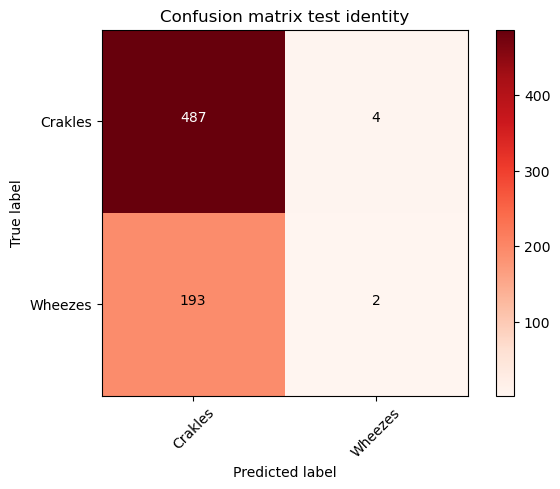

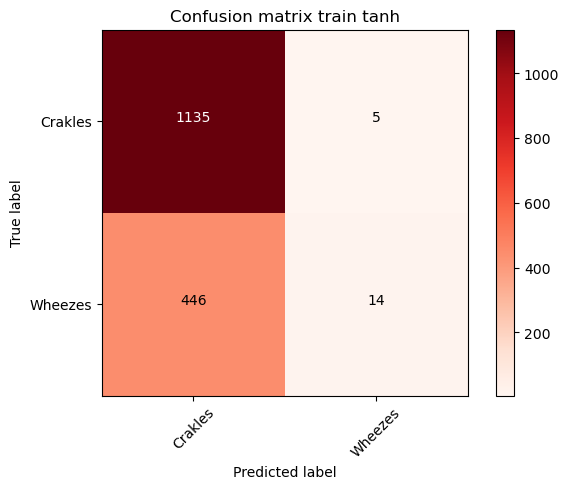

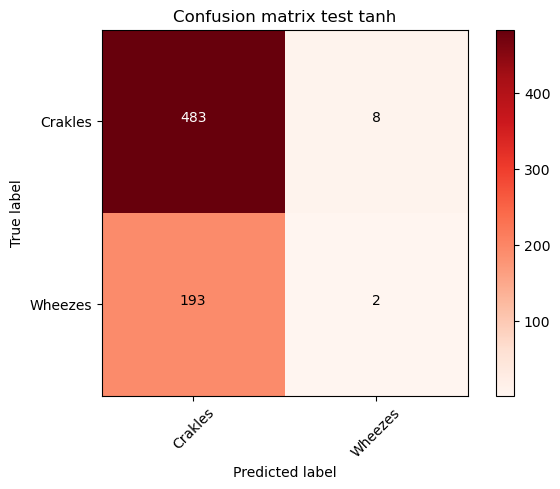

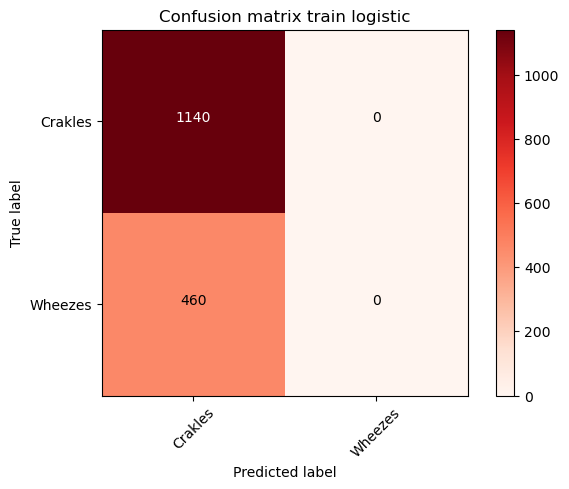

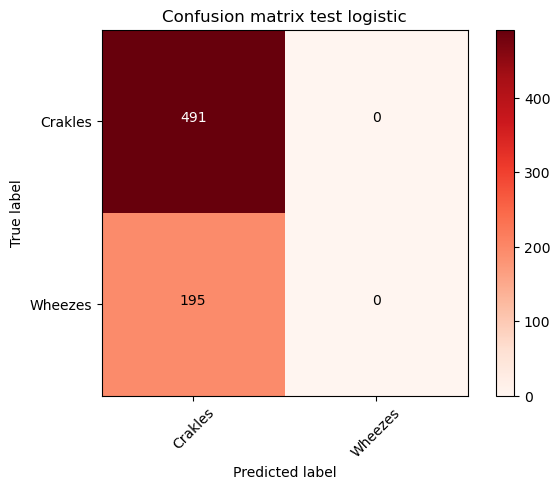

In [245]:
con=(d2.Estado.values==0)|(d2.Estado.values==2)
x=d2.drop(["Estado"],axis=1)[con]
y=d2.Estado.values[con]
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)

print (Xtv.shape, Xts.shape)
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,['Crakles','Wheezes'])

# 4. Normales, silibantes y crepitantes

(4919, 3) (4919,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(3443, 3) (1476, 3)
Train  relu
------------
Square error: 0.5361603252977055
              precision    recall  f1-score   support

           0       0.51      0.37      0.43      1165
           1       0.58      0.83      0.68      1810
           2       0.00      0.00      0.00       468

    accuracy                           0.56      3443
   macro avg       0.36      0.40      0.37      3443
weighted avg       0.48      0.56      0.50      3443

Confusion matrix, without normalization
[[ 428  737    0]
 [ 308 1502    0]
 [ 111  357    0]]
------------
Test  relu
Square error: 0.5264227642276422
              precision    recall  f1-score   support

           0       0.45      0.35      0.39       466
           1       0.60      0.82      0.69       823
           2       0.00      0.00      0.00       187

    accuracy                           0.57      1476
   macro avg       0.35      0.39      0.36    

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  identity
------------
Square error: 0.47894278245715943
              precision    recall  f1-score   support

           0       0.55      0.05      0.10      1165
           1       0.53      0.98      0.69      1810
           2       0.00      0.00      0.00       468

    accuracy                           0.53      3443
   macro avg       0.36      0.34      0.26      3443
weighted avg       0.47      0.53      0.40      3443

Confusion matrix, without normalization
[[  64 1101    0]
 [  38 1772    0]
 [  14  454    0]]
------------
Test  identity
Square error: 0.44308943089430897
              precision    recall  f1-score   support

           0       0.62      0.06      0.11       466
           1       0.57      0.99      0.72       823
           2       0.00      0.00      0.00       187

    accuracy                           0.57      1476
   macro avg       0.39      0.35      0.28      1476
weighted avg       0.51      0.57      0.44      1476

Confusion matrix, 

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  tanh
------------
Square error: 0.5605576532094104
              precision    recall  f1-score   support

           0       0.49      0.45      0.47      1165
           1       0.59      0.78      0.67      1810
           2       0.00      0.00      0.00       468

    accuracy                           0.56      3443
   macro avg       0.36      0.41      0.38      3443
weighted avg       0.48      0.56      0.51      3443

Confusion matrix, without normalization
[[ 527  638    0]
 [ 404 1406    0]
 [ 140  328    0]]
------------
Test  tanh
Square error: 0.5623306233062331
              precision    recall  f1-score   support

           0       0.44      0.44      0.44       466
           1       0.62      0.75      0.68       823
           2       0.00      0.00      0.00       187

    accuracy                           0.56      1476
   macro avg       0.35      0.40      0.37      1476
weighted avg       0.48      0.56      0.52      1476

Confusion matrix, without no

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  logistic
------------
Square error: 0.4742956723787395
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1165
           1       0.53      1.00      0.69      1810
           2       0.00      0.00      0.00       468

    accuracy                           0.53      3443
   macro avg       0.18      0.33      0.23      3443
weighted avg       0.28      0.53      0.36      3443

Confusion matrix, without normalization
[[   0 1165    0]
 [   0 1810    0]
 [   0  468    0]]
------------
Test  logistic
Square error: 0.4424119241192412
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       466
           1       0.56      1.00      0.72       823
           2       0.00      0.00      0.00       187

    accuracy                           0.56      1476
   macro avg       0.19      0.33      0.24      1476
weighted avg       0.31      0.56      0.40      1476

Confusion matrix, wi

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

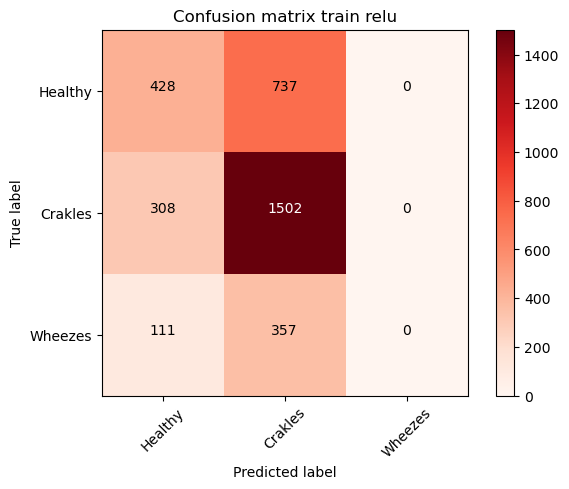

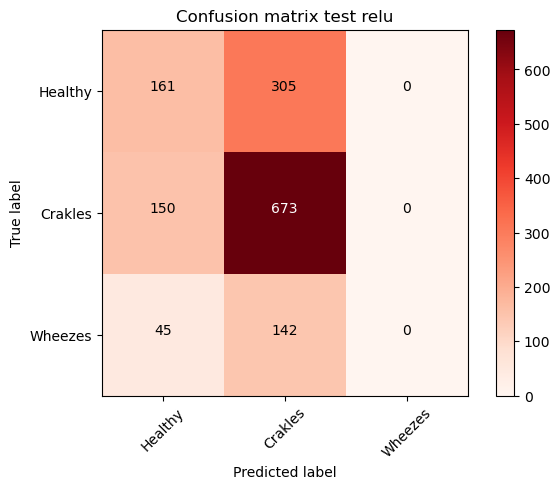

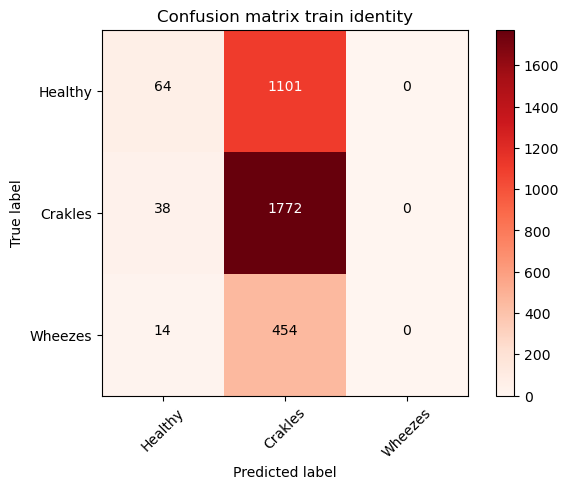

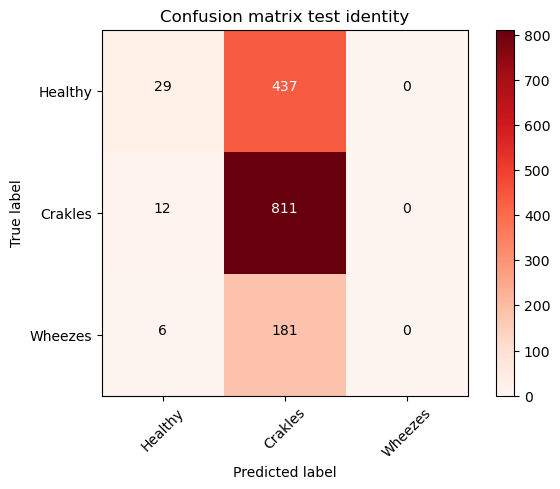

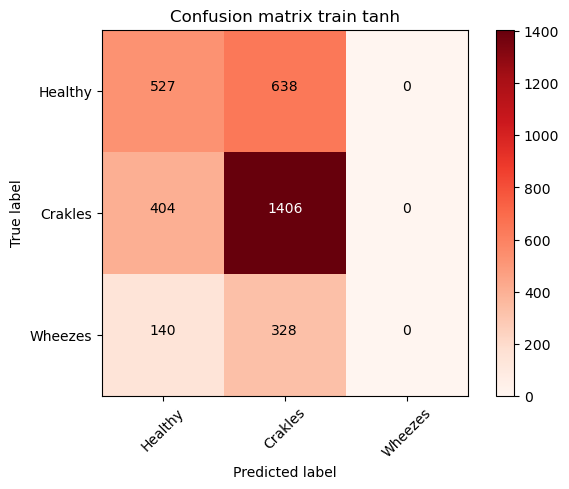

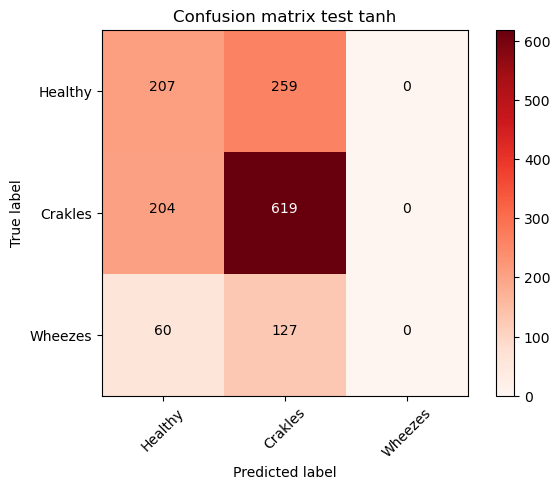

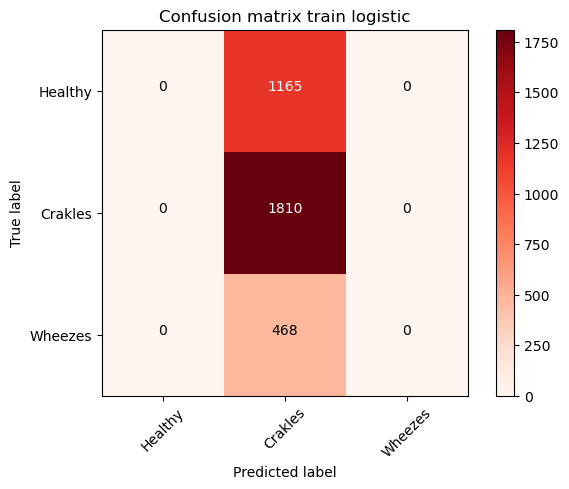

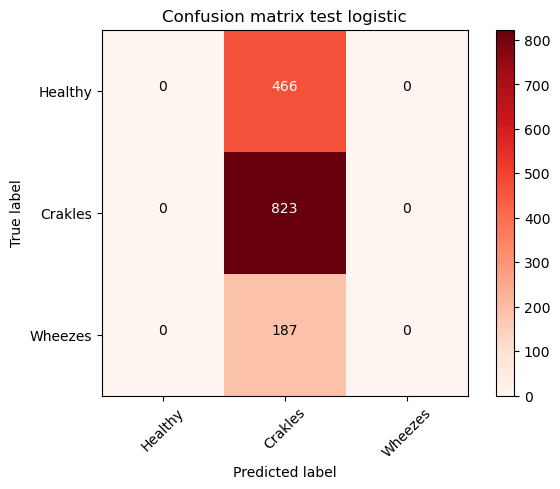

In [246]:
x=d2.drop(["Estado"],axis=1)
y=d2.Estado.values
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)

print (Xtv.shape, Xts.shape)
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,["Healthy",'Crakles','Wheezes'])

In [229]:
from sklearn import svm

clf = svm.NuSVC(gamma='auto')
clf.fit(Xtv,ytv)

predict_train = clf.predict(Xtv)
predict_test = clf.predict(Xts)

target_names = ['Sano','Crakles']
print(classification_report(ytv,predict_train,target_names=target_names))

print(classification_report(yts,predict_test,target_names=target_names))

              precision    recall  f1-score   support

        Sano       0.50      0.31      0.38      1179
     Crakles       0.64      0.79      0.71      1805

    accuracy                           0.60      2984
   macro avg       0.57      0.55      0.55      2984
weighted avg       0.58      0.60      0.58      2984

              precision    recall  f1-score   support

        Sano       0.42      0.29      0.34       452
     Crakles       0.67      0.79      0.72       828

    accuracy                           0.61      1280
   macro avg       0.55      0.54      0.53      1280
weighted avg       0.58      0.61      0.59      1280

